In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('/home/behtash/My_Packages/')

import sklearn
from imblearn import over_sampling
from rfpimp import *
from scipy import stats
import seaborn as sns
import datetime as dt

import eli5
from eli5.sklearn import PermutationImportance                 # For sklearn models
from eli5.permutation_importance import get_score_importances  # For non-sklearn models


from bb_env import setup
pd, np, resample, random, stats, plt, bb_plot, RFC, BRF, RFR, metrics, mdl_slc = setup.imports()
plt.rcParams.update({ 'xtick.labelsize':'16','ytick.labelsize':'16' ,'xtick.color' : 'black', 'axes.labelcolor' : 'black' , 'ytick.color' : 'black', 
                    'figure.facecolor': 'white', 'axes.edgecolor': 'black'})


Set these variables to the imports function output
pd, np, resample, random, stats, bb_plot, RFC, BRF, RFR, metrics, mdl_slc


# In this notebook: 
    - ML models used and compared: Random Forest, Weighted Random Forest, Balanced Random Forest
    - Preprocessing (may or may not be used): PCA (dimensionality reduction and reducing feaure|feature correlation) 
    - SMOTE (oversampling the minority class)
    - Fearture importances (generic permutation importance for any ML model) | includes confidence intervals
    - Feature-label correlations and comparison to feature importances  | includes confidence intervals
    - Metrics used: Recall / Precision / F1 / ROC and AUC /Accurancy: for reference only 

# Useful references 
- [Using Random Forests to Learn Imbalanced Data] (https://statistics.berkeley.edu/sites/default/files/tech-reports/666.pdf) 
- [Synthetic Minority Over-sampling Technique] (https://jair.org/index.php/jair/article/view/10302/24590)
- [Beaware default Random Forest Importances] (https://explained.ai/rf-importance/index.html)
- [Permuation Importance] (https://eli5.readthedocs.io/en/latest/blackbox/permutation_importance.html)
- [Optimal Thresholding of Classifiers to Maximize F1 Measure] (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4442797/)
- [Scalable Learning for Non-Decomposable Objectives] (https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45573.pdf)

# Data 
- Minority percentage:  2.3%
- Data is available @ [OpenML Mamography data] (https://www.openml.org/d/310)
- Citation: 
Woods, K., Doss, C., Bowyer, K., Solka, J., Preibe, C., & Kegelmyer, P. (1993). Comparative evaluation
of pattern recognition techniques for detection of microcalcifications in mammography. International
Journal of Pattern Recognition and Artificial Intelligence, 7, 1417–1436

# Import the data, Split features/label and perform PCA if necessary

In [90]:
df = pd.read_csv('Mammography.csv') 
df = df.reindex(np.random.permutation(len(df))).reset_index(drop=True)   


X,y = df.iloc[:,:-1], df.iloc[:,-1]
y =  pd.DataFrame([not ele[1]=='-' for ele in y], columns=['cancer']).astype(int) 
Decomp_Flag = 0
if Decomp_Flag == 1:
    # Decomposition 
    X =  sklearn.preprocessing.MinMaxScaler().fit(X).transform(X)
    X =  sklearn.decomposition.PCA().fit(X).transform(X)
    X =  pd.DataFrame(X)
    

df = pd.DataFrame(columns = df.columns) #['attr1','attr2','attr3','attr4','attr5','attr6' ,'cancer']
df = pd.concat([X,y],  axis=1)


# Define the models

In [91]:
RFC_mdl = RFC(n_estimators=100, n_jobs=-1,)                             # Random forest
WRF_mdl = RFC(n_estimators=100, class_weight= {0:1,1:3}, n_jobs=-1)     # Weighted random forest
BRF_mdl = BRF(n_estimators=100, n_jobs=-1)                              # Balanced random forest


# Initial cross validation: data set is small. CV is necessary. Not dealing with a time series. 

In [92]:
RFC_xv = mdl_slc.cross_validate(RFC_mdl, X, np.array(y).reshape(len(y),), cv =10, scoring=['f1', 'recall', 'precision']) 
WRF_xv = mdl_slc.cross_validate(WRF_mdl, X, np.array(y).reshape(len(y),), cv =10, scoring=['f1', 'recall', 'precision'])
BRF_xv = mdl_slc.cross_validate(BRF_mdl, X, np.array(y).reshape(len(y),), cv =10, scoring=['f1', 'recall', 'precision'])

In [93]:
RFC_xv.keys()

dict_keys(['fit_time', 'score_time', 'test_f1', 'train_f1', 'test_recall', 'train_recall', 'test_precision', 'train_precision'])

# Standard Random Forest

In [94]:
print('Recall', round(np.average(RFC_xv['test_recall']),2), '| Precision: ', round(np.average(RFC_xv['test_precision']),2), '| F1: ', round(np.average(RFC_xv['test_f1']),2))

Recall 0.55 | Precision:  0.89 | F1:  0.67


# RF: ROC and Precision-Recall Curves

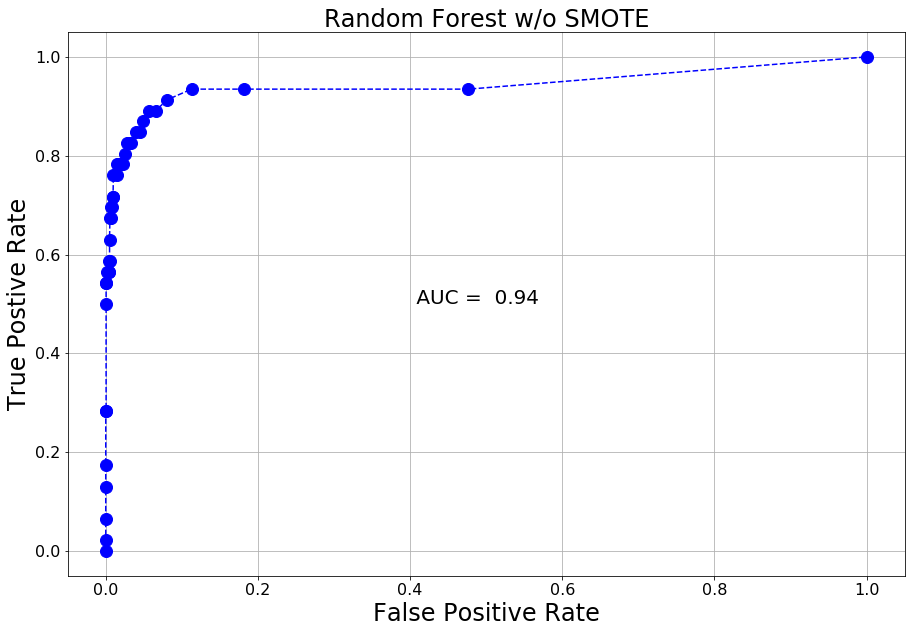

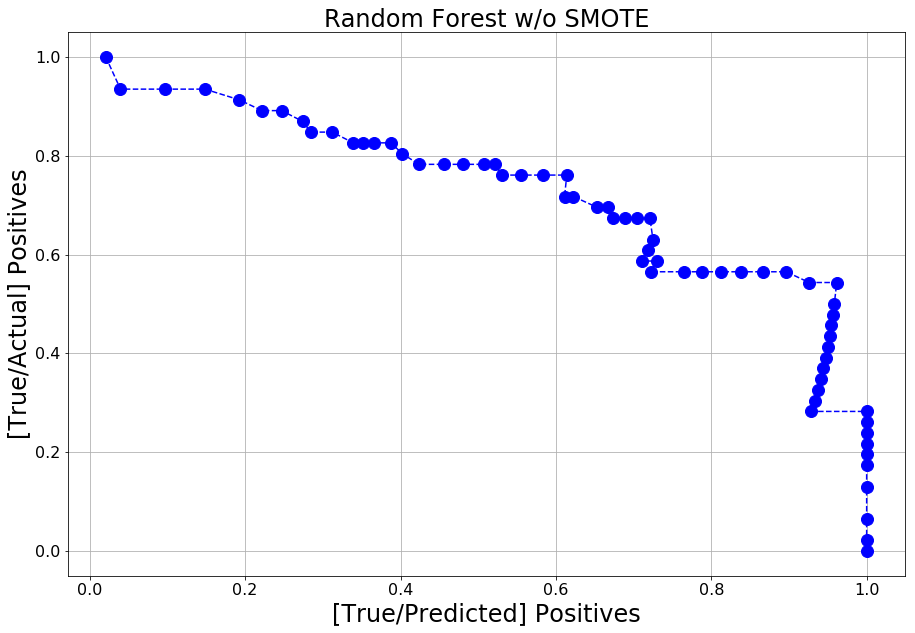

In [97]:
# Train Validation split
fold        = 0
val_frac    = 0.2
Nsamples    = int(val_frac * len(df))   
val_idx     = np.arange(fold * Nsamples, (fold+1) * Nsamples) 
trn_idx     = np.array(list(set(np.arange(len(df))) - set(val_idx)))
train, val  = df.iloc[trn_idx] , df.iloc[val_idx] 

# Fit the model for ROC and AUC 
RFC_mdl_fitted  = RFC_mdl.fit(train.iloc[:,:-1], train.iloc[:,-1] )

# Extract the predicted probabilities and evaluate various metrics 
probs         = RFC_mdl_fitted.predict_proba(val.iloc[:,:-1])
fpr, tpr, thr = metrics.roc_curve(val.iloc[:,-1], probs[:,1])
auc           = round(metrics.roc_auc_score(val.iloc[:,-1], probs[:,1]),2)
prc, rec, thr = metrics.precision_recall_curve(val.iloc[:,-1], probs[:,1])

# Plot the ROC curve annotated with AUC
plt.figure(figsize=((15,10)))
plt.title('Random Forest w/o SMOTE', fontsize=24)
plt.plot(fpr, tpr, 'b--o', label = 'Recall', markersize = 12)   # ROC
plt.text(0.4,0.5, f' AUC =  {auc}', fontsize=20)
plt.xlabel('False Positive Rate', fontsize=24)
plt.ylabel('True Postive Rate', fontsize=24)
plt.grid()


# Plot the Precision-Recall curve
plt.figure(figsize=((15,10)))
plt.title('Random Forest w/o SMOTE', fontsize=24)
plt.plot(prc, rec, 'b--o', label = 'Recall', markersize = 12)   # ROC
plt.xlabel('[True/Predicted] Positives', fontsize=24)
plt.ylabel('[True/Actual] Positives', fontsize=24)
plt.grid()

# Feature studies 
- Importances
    - Variable Permuation  (ML model invariant)
    - Gini                 (For Random Forests)
- Feature-label correlations

CPU times: user 40.5 s, sys: 5.92 s, total: 46.4 s
Wall time: 45.4 s


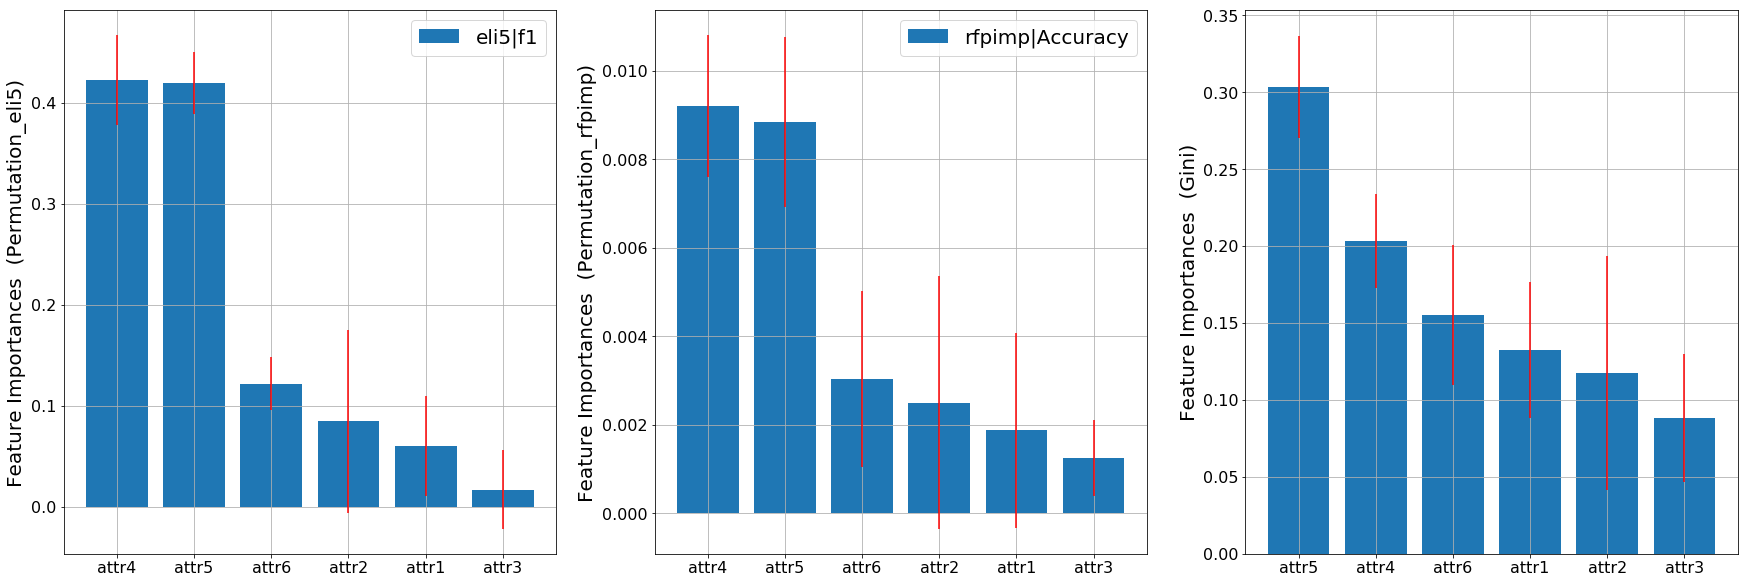

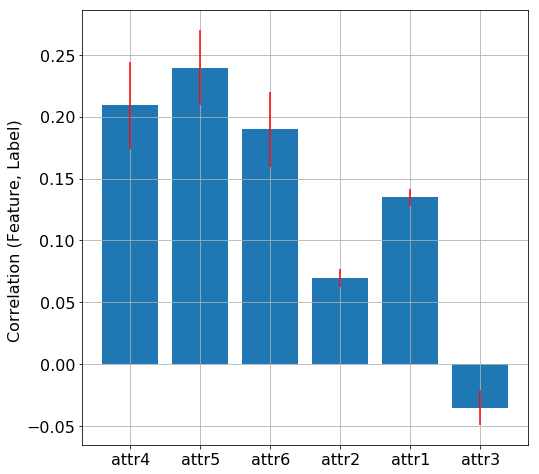

In [270]:
%%time 
imp_rfpimp  = pd.DataFrame(columns = ['Feature', 'Importance'])
imp_eli5    = pd.DataFrame(columns = ['Feature', 'Importance'])


Nfold = 10
f_l_corr = np.zeros((len(df.columns), Nfold))
for fold in range(Nfold):
    
    # Train Validation split
    val_frac    = 1/Nfold 
    Nsamples    = int(val_frac * len(df))
    Nsamples    = int(val_frac * len(df))   
    val_idx     = np.arange(fold * Nsamples, (fold+1) * Nsamples) 
    trn_idx     = np.array(list(set(np.arange(len(df))) - set(val_idx)))
    train, val  = df.iloc[trn_idx] , df.iloc[val_idx] 
    
    
    # Get the correlation of each feature with the label 
    corrs          = stats.spearmanr(val)
    f_l_corr[:,fold] = corrs[0][:,-1]

    
    
    
    # Fit the ML model 
    RFC_mdl_fitted  = RFC_mdl.fit(train.iloc[:,:-1], train.iloc[:,-1] )
    
    
    # Get the permuation importance of features based on the val set =============================================================================
    # Use the validation set along with a trained model on each fold     
    X_val, y_val = val.iloc[:,:-1], val.iloc[:,-1]
    
    # Using the "rfpimp" package   | Accuracy based
    imp_rfpimp   = imp_rfpimp.append(importances(RFC_mdl_fitted, X_val, y_val ).reset_index(), ignore_index=True)
    
    # Using "eli5" package         | Can choose the scoring metrics
    imp_score = 'f1'
    perm = PermutationImportance(RFC_mdl_fitted, scoring=imp_score).fit(X_val, y_val)
    imp_eli5     = imp_eli5.append(pd.DataFrame(list(zip(list(train.columns[:-1]), perm.feature_importances_)), columns=['Feature', 'Importance']))
    
    # ============================================================================================================================================
    
    
    
#=====  Variable importance by permutation from rfpimp package   ========================     
# rfpimp
# Take the mean of the results from CV and sort based on importance
xv_imp_rfpimp      = imp_rfpimp.groupby('Feature').mean().reset_index()
xv_imp_rfpimp.sort_values('Importance',ascending=False, inplace=True)

# Take the standard deviation of the results from CV and reorder to follow sorted feature importance order
xv_imp_rfpimp_std = imp_rfpimp.groupby('Feature').std().reset_index().rename({'Importance': 'Sigma'}, axis='columns')
xv_imp_rfpimp_std.reindex(xv_imp_rfpimp.index)

# Just a convenience step to get rid of a duplicate column (transpose --> drop duplicate rows --> transpose)
xv_imp_rfpimp      = pd.concat([xv_imp_rfpimp , xv_imp_rfpimp_std], axis=1).T.drop_duplicates().T
xv_imp_rfpimp.sort_values('Importance', ascending=False , inplace=True)




#=====  Variable importance by permutation from eli5 package   ========================     
# eli5
# Take the mean of the results from CV and sort based on importance
xv_imp_eli5      = imp_eli5.groupby('Feature').mean().reset_index()
xv_imp_eli5.sort_values('Importance',ascending=False, inplace=True)

# Take the standard deviation of the results from CV and reorder to follow sorted feature importance order
xv_imp_eli5_std = imp_eli5.groupby('Feature').std().reset_index().rename({'Importance': 'Sigma'}, axis='columns')
xv_imp_eli5_std.reindex(xv_imp_eli5.index)

# Just a convenience step to get rid of a duplicate column (transpose --> drop duplicate rows --> transpose)
xv_imp_eli5      = pd.concat([xv_imp_eli5 , xv_imp_eli5_std], axis=1).T.drop_duplicates().T
xv_imp_eli5.sort_values('Importance', ascending=False , inplace=True)





#### Gini importance         ============================================

gini_imp = pd.DataFrame(columns=['Feature','Gini_Importance'])
gini_imp['Feature'] = train.columns[:-1]
gini_imp['Gini_Importance'] = RFC_mdl_fitted.feature_importances_

gini_imp     = gini_imp.sort_values(by='Gini_Importance', ascending=False)
gini_imp_std = np.std([tree.feature_importances_ for tree in RFC_mdl_fitted.estimators_], axis=0)
gini_imp_std[list(gini_imp.index)]


####   Feature label correlations =========================================

# Get the mean and standard deviation of correlation(feature, label) for CV 
f_l_corr_mean  = np.mean(f_l_corr, axis=1)[xv_imp_eli5.index]
f_l_corr_std = np.std(f_l_corr, axis=1)[xv_imp_eli5.index]






# Figures ========================================================================================================


fig = plt.figure(figsize =(30,10))
#plt.title('Based on Accuracy', fontsize=40)

fig.add_subplot(131)
plt.bar(xv_imp_eli5.Feature, xv_imp_eli5.Importance, yerr=xv_imp_eli5_std.Sigma, align='center', ecolor='red',  label= f'eli5|{imp_score}')
plt.ylabel('Feature Importances  (Permutation_eli5)', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)


# -----------


fig.add_subplot(132)
plt.bar(xv_imp_rfpimp.Feature, xv_imp_rfpimp.Importance, yerr=xv_imp_rfpimp_std.Sigma, align='center', ecolor='red',  label= 'rfpimp|Accuracy')
plt.ylabel('Feature Importances  (Permutation_rfpimp)', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)


# -----------


fig.add_subplot(133)
#sns.heatmap(corrs,cmap = 'gray',linewidths=0.5)
plt.bar(gini_imp.Feature, gini_imp.Gini_Importance, yerr=gini_imp_std, align='center', ecolor='red')
plt.ylabel('Feature Importances  (Gini)', fontsize=20)
plt.grid(True)

# -----------

plt.figure(figsize =(8,8))
#sns.heatmap(corrs,cmap = 'gray',linewidths=0.5)
plt.bar(xv_imp_eli5.Feature, f_l_corr_mean, yerr=f_l_corr_std, align='center', ecolor='red')
plt.ylabel('Correlation (Feature, Label) ', fontsize=16)
plt.grid(True)







## Pair plot

<Figure size 1296x432 with 0 Axes>

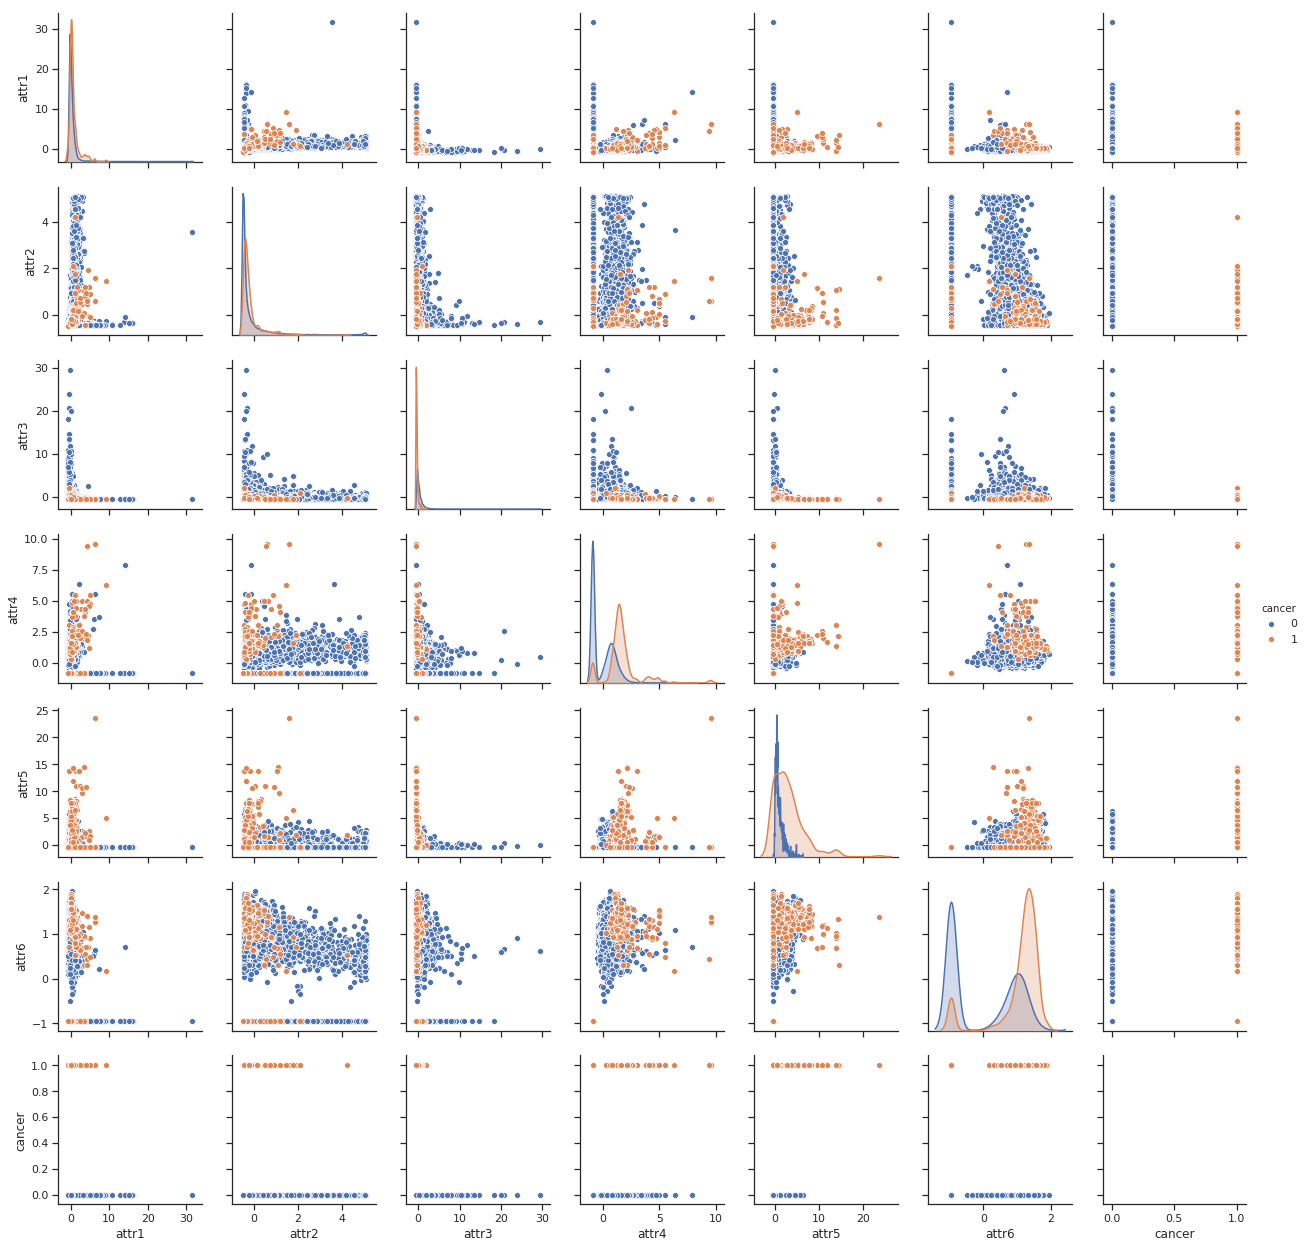

In [174]:
import warnings
warnings.simplefilter(action='ignore', category=RuntimeWarning)

fig = plt.figure(figsize =(18,6))
sns.set(style="ticks", color_codes=True)
sns.pairplot(df, hue='cancer')

# Weighted Random Forest

In [67]:
print('Recall', round(np.average(WRF_xv['test_recall']),2), '| Precision: ', round(np.average(WRF_xv['test_precision']),2), '| F1: ', round(np.average(WRF_xv['test_f1']),2))

Recall 0.57 | Precision:  0.89 | F1:  0.69


# Balanced Random Forest

In [68]:
print('Recall', round(np.average(BRF_xv['test_recall']),2), '| Precision: ', round(np.average(BRF_xv['test_precision']),2), '| F1: ', round(np.average(BRF_xv['test_f1']),2))

Recall 0.89 | Precision:  0.23 | F1:  0.37


# Close look at performance metrics and the effect of probability thresholds for classification
- Fit the models and evaluate recall, precision and F1 for various folds and probability thresholds

# Case A: No SMOTE is used 

In [69]:
Nfold = 10   # Data set size is small 
Nth   = 81

# Set the threshold array
thresh_arr = np.linspace(0.1, 0.9, Nth)
# Initialize metrics storage arrays
RFC_recall, RFC_precision, RFC_f1  = np.zeros((Nfold,Nth)) , np.zeros((Nfold,Nth)), np.zeros((Nfold,Nth))
WRF_recall, WRF_precision, WRF_f1  = np.zeros((Nfold,Nth)) , np.zeros((Nfold,Nth)), np.zeros((Nfold,Nth))
BRF_recall, BRF_precision, BRF_f1  = np.zeros((Nfold,Nth)) , np.zeros((Nfold,Nth)), np.zeros((Nfold,Nth))


for fold in range(Nfold):
    print(fold)
    # Train Validation split
    val_frac    = 1/Nfold 
    Nsamples    = int(val_frac * len(df))
    val_idx     = np.arange(fold * Nsamples, (fold+1) * Nsamples) 
    trn_idx     = np.array(list(set(np.arange(len(df))) - set(val_idx)))
    train, val  = df.iloc[trn_idx] , df.iloc[val_idx] 

    # Perform SMOTE if desired 
    SMOTE_Flag = 0
    if SMOTE_Flag == 1:
        # Oversample the training data
        X_trn, y_trn = train.iloc[:,:-1], train.iloc[:,-1]
        sm           = over_sampling.SMOTE()
        X_ovr, y_ovr = sm.fit_resample(X_trn,y_trn)
        train        = np.concatenate((X_ovr, y_ovr.reshape(len(y_ovr),1)), axis=1)
        train        = pd.DataFrame(train)

    # Fit the models     
    RFC_mdl_fitted  = RFC_mdl.fit(train.iloc[:,:-1], train.iloc[:,-1] )
    WRF_mdl_fitted  = WRF_mdl.fit(train.iloc[:,:-1], train.iloc[:,-1] )
    BRF_mdl_fitted  = BRF_mdl.fit(train.iloc[:,:-1], train.iloc[:,-1] )
    
    
    
    # Vary the probability threshold and evalue recall, precision, F1
    for idx,th in enumerate(thresh_arr):

        # RF
        RFC_probs = RFC_mdl_fitted.predict_proba(val.iloc[:,:-1])[:,1] > th
        #
        tn, fp, fn, tp = metrics.confusion_matrix(val.iloc[:,-1] , RFC_probs).ravel()
        RFC_recall[fold, idx]   = tp/(tp+fn)
        RFC_precision[fold,idx] = tp/(tp+fp)
        RFC_f1[fold,idx]        = 2*(RFC_precision[fold,idx] * RFC_recall[fold,idx])/(RFC_precision[fold,idx] + RFC_recall[fold,idx])

        
        # WRF
        WRF_probs = WRF_mdl_fitted.predict_proba(val.iloc[:,:-1])[:,1] > th
        #
        tn, fp, fn, tp = metrics.confusion_matrix(val.iloc[:,-1] , WRF_probs).ravel()
        WRF_recall[fold, idx]   = tp/(tp+fn)
        WRF_precision[fold,idx] = tp/(tp+fp)
        WRF_f1[fold,idx]        = 2*(WRF_precision[fold,idx] * WRF_recall[fold,idx])/(WRF_precision[fold,idx] + WRF_recall[fold,idx])

        
        # BRF
        BRF_probs = BRF_mdl_fitted.predict_proba(val.iloc[:,:-1])[:,1] > th 
        #
        tn, fp, fn, tp = metrics.confusion_matrix(val.iloc[:,-1] , BRF_probs).ravel()
        BRF_recall[fold, idx]   = tp/(tp+fn)
        BRF_precision[fold,idx] = tp/(tp+fp)
        BRF_f1[fold,idx]        = 2*(BRF_precision[fold,idx] * BRF_recall[fold,idx])/(BRF_precision[fold,idx] + BRF_recall[fold,idx])


0
1
2
3
4
5
6
7
8
9


# Recall, Precision, F1 with varied threshold (No SMOTE)

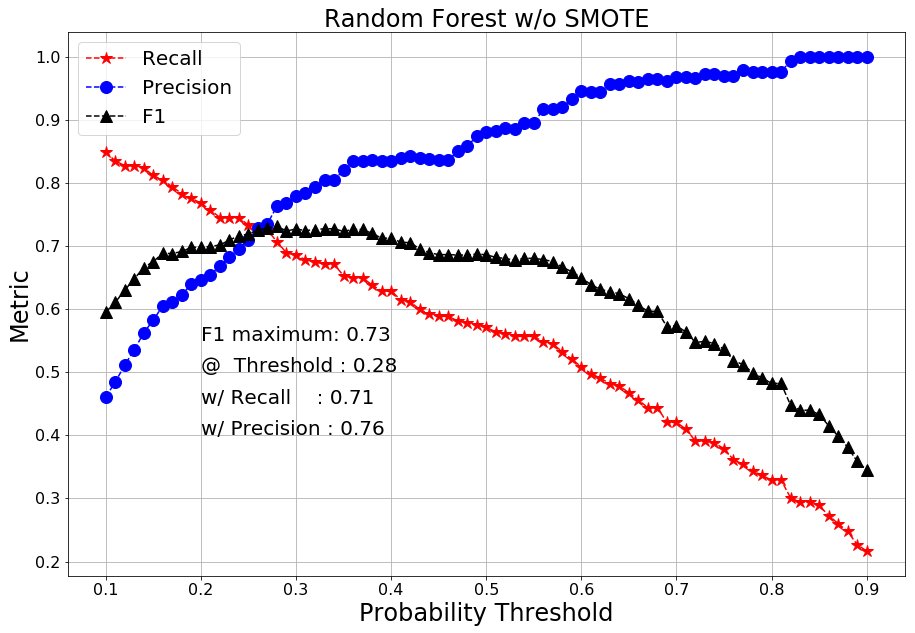

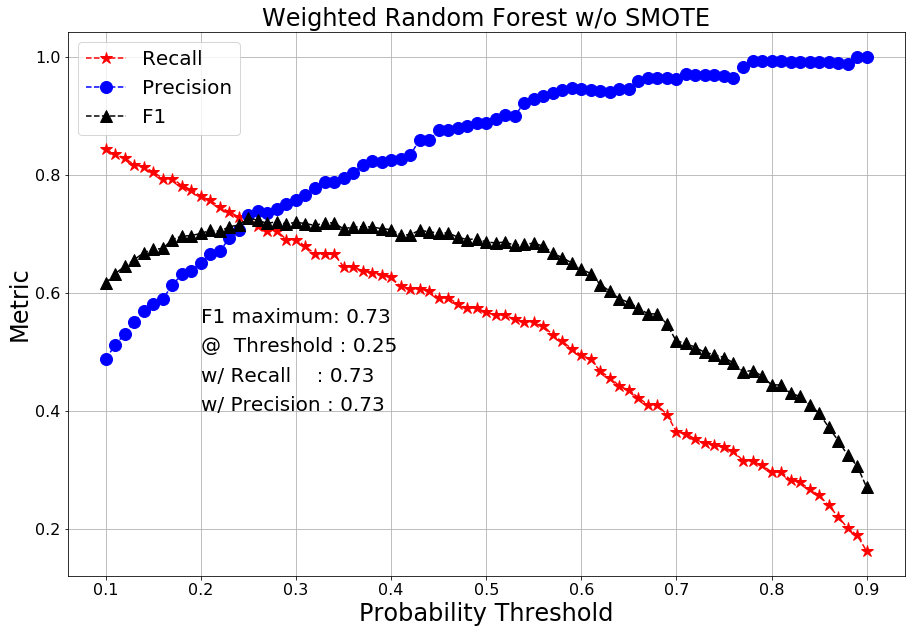

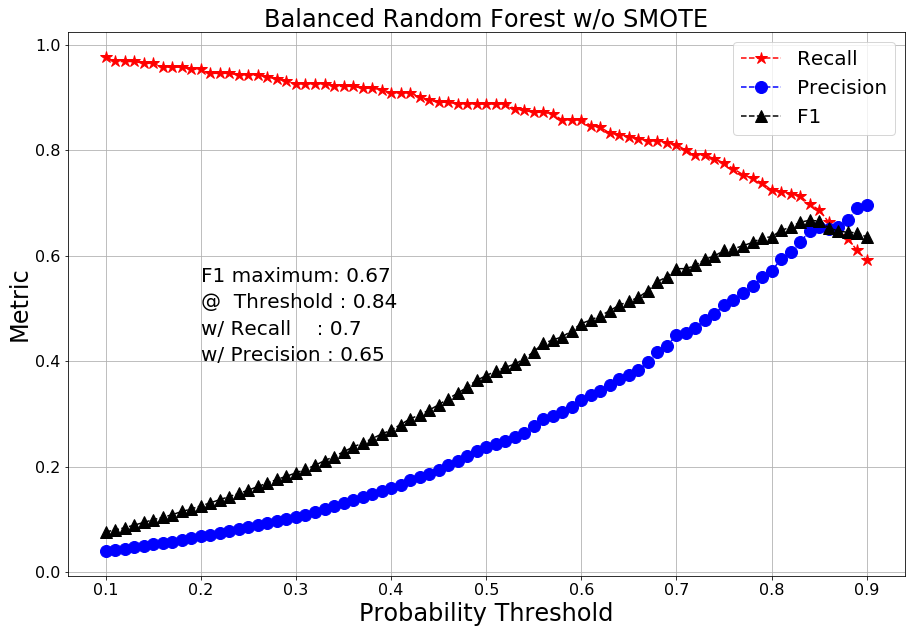

In [70]:
recall    = np.mean(RFC_recall, axis=0)
precision = np.mean(RFC_precision, axis=0)
f1        = np.mean(RFC_f1, axis=0)
    

plt.figure(figsize=((15,10)))
plt.title('Random Forest w/o SMOTE', fontsize=24)
plt.plot(thresh_arr, recall,'r--*', label = 'Recall', markersize = 12)
plt.plot(thresh_arr, precision,'b--o', label = 'Precision', markersize = 12)
plt.plot(thresh_arr, f1,'k--^', label = 'F1', markersize = 12)
plt.xlabel('Probability Threshold', fontsize=24)
plt.ylabel('Metric', fontsize=24)

plt.legend(prop={'size': 20}) 
plt.text(0.2, 0.55, f'F1 maximum: {round(max(f1),2)}', fontsize=20)
plt.text(0.2, 0.5,  f'@  Threshold : {round(thresh_arr[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.45, f'w/ Recall    : {round(recall[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.4,  f'w/ Precision : {round(precision[np.argmax(f1)],2)}', fontsize=20)
plt.grid()
plt.savefig('Mam_RF_NoSMOTE_'+dt.datetime.today().strftime('%Y-%m-%d_%H-%M')+'.pdf')
# ---------------------------------------------------------------------------------------------

recall    = np.mean(WRF_recall, axis=0)
precision = np.mean(WRF_precision, axis=0)
f1        = np.mean(WRF_f1, axis=0)
    

plt.figure(figsize=((15,10)))
plt.title('Weighted Random Forest w/o SMOTE', fontsize=24)
plt.plot(thresh_arr, recall,'r--*', label = 'Recall', markersize = 12)
plt.plot(thresh_arr, precision,'b--o', label = 'Precision', markersize = 12)
plt.plot(thresh_arr, f1,'k--^', label = 'F1', markersize = 12)
plt.xlabel('Probability Threshold', fontsize=24)
plt.ylabel('Metric', fontsize=24)


plt.legend(prop={'size': 20}) 
plt.text(0.2, 0.55, f'F1 maximum: {round(max(f1),2)}', fontsize=20)
plt.text(0.2, 0.5,  f'@  Threshold : {round(thresh_arr[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.45, f'w/ Recall    : {round(recall[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.4,  f'w/ Precision : {round(precision[np.argmax(f1)],2)}', fontsize=20)
plt.grid()
plt.savefig('Mam_WRF_NoSMOTE_'+dt.datetime.today().strftime('%Y-%m-%d_%H-%M')+'.pdf')

# ---------------------------------------------------------------------------------------------

recall    = np.mean(BRF_recall, axis=0)
precision = np.mean(BRF_precision, axis=0)
f1        = np.mean(BRF_f1, axis=0)
    

plt.figure(figsize=((15,10)))
plt.title('Balanced Random Forest w/o SMOTE', fontsize=24)
plt.plot(thresh_arr, recall,'r--*', label = 'Recall', markersize = 12)
plt.plot(thresh_arr, precision,'b--o', label = 'Precision', markersize = 12)
plt.plot(thresh_arr, f1,'k--^', label = 'F1', markersize = 12)
plt.xlabel('Probability Threshold', fontsize=24)
plt.ylabel('Metric', fontsize=24)

plt.legend(prop={'size': 20}) 
plt.text(0.2, 0.55, f'F1 maximum: {round(max(f1),2)}', fontsize=20)
plt.text(0.2, 0.5,  f'@  Threshold : {round(thresh_arr[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.45, f'w/ Recall    : {round(recall[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.4,  f'w/ Precision : {round(precision[np.argmax(f1)],2)}', fontsize=20)
plt.grid()
plt.savefig('Mam_BRF_NoSMOTE_'+dt.datetime.today().strftime('%Y-%m-%d_%H-%M')+'.pdf')



## Case B: SMOTE is used before training 

In [71]:
Nfold = 10
Nth   = 81

# Set the threshold array
thresh_arr = np.linspace(0.1, 0.9, Nth)
# Initialize metrics storage arrays
RFC_recall, RFC_precision, RFC_f1  = np.zeros((Nfold,Nth)) , np.zeros((Nfold,Nth)), np.zeros((Nfold,Nth))
WRF_recall, WRF_precision, WRF_f1  = np.zeros((Nfold,Nth)) , np.zeros((Nfold,Nth)), np.zeros((Nfold,Nth))
BRF_recall, BRF_precision, BRF_f1  = np.zeros((Nfold,Nth)) , np.zeros((Nfold,Nth)), np.zeros((Nfold,Nth))


for fold in range(Nfold):
    print(fold)
    # Train Validation split
    val_frac    = 1/Nfold 
    Nsamples    = int(val_frac * len(df))
    val_idx     = np.arange(fold * Nsamples, (fold+1) * Nsamples) 
    trn_idx     = np.array(list(set(np.arange(len(df))) - set(val_idx)))
    train, val  = df.iloc[trn_idx] , df.iloc[val_idx] 

    # Perform SMOTE if desired 
    SMOTE_Flag = 1
    if SMOTE_Flag == 1:
        # Oversample the training data
        X_trn, y_trn = train.iloc[:,:-1], train.iloc[:,-1]
        sm           = over_sampling.SMOTE()
        X_ovr, y_ovr = sm.fit_resample(X_trn,y_trn)
        train        = np.concatenate((X_ovr, y_ovr.reshape(len(y_ovr),1)), axis=1)
        train        = pd.DataFrame(train)

    # Fit the models     
    RFC_mdl_fitted  = RFC_mdl.fit(train.iloc[:,:-1], train.iloc[:,-1] )
    WRF_mdl_fitted  = WRF_mdl.fit(train.iloc[:,:-1], train.iloc[:,-1] )
    BRF_mdl_fitted  = BRF_mdl.fit(train.iloc[:,:-1], train.iloc[:,-1] )
    
    
    
    # Vary the probability threshold and evalue recall, precision, F1
    for idx,th in enumerate(thresh_arr):

        # RF
        RFC_probs = RFC_mdl_fitted.predict_proba(val.iloc[:,:-1])[:,1] > th
        #
        tn, fp, fn, tp = metrics.confusion_matrix(val.iloc[:,-1] , RFC_probs).ravel()
        RFC_recall[fold, idx]   = tp/(tp+fn)
        RFC_precision[fold,idx] = tp/(tp+fp)
        RFC_f1[fold,idx]        = 2*(RFC_precision[fold,idx] * RFC_recall[fold,idx])/(RFC_precision[fold,idx] + RFC_recall[fold,idx])

        
        # WRF
        WRF_probs = WRF_mdl_fitted.predict_proba(val.iloc[:,:-1])[:,1] > th
        #
        tn, fp, fn, tp = metrics.confusion_matrix(val.iloc[:,-1] , WRF_probs).ravel()
        WRF_recall[fold, idx]   = tp/(tp+fn)
        WRF_precision[fold,idx] = tp/(tp+fp)
        WRF_f1[fold,idx]        = 2*(WRF_precision[fold,idx] * WRF_recall[fold,idx])/(WRF_precision[fold,idx] + WRF_recall[fold,idx])

        
        # BRF
        BRF_probs = BRF_mdl_fitted.predict_proba(val.iloc[:,:-1])[:,1] > th 
        #
        tn, fp, fn, tp = metrics.confusion_matrix(val.iloc[:,-1] , BRF_probs).ravel()
        BRF_recall[fold, idx]   = tp/(tp+fn)
        BRF_precision[fold,idx] = tp/(tp+fp)
        BRF_f1[fold,idx]        = 2*(BRF_precision[fold,idx] * BRF_recall[fold,idx])/(BRF_precision[fold,idx] + BRF_recall[fold,idx])


0
1
2
3
4
5
6
7
8
9


# Recall, Precision, F1 with varied threshold (With SMOTE)

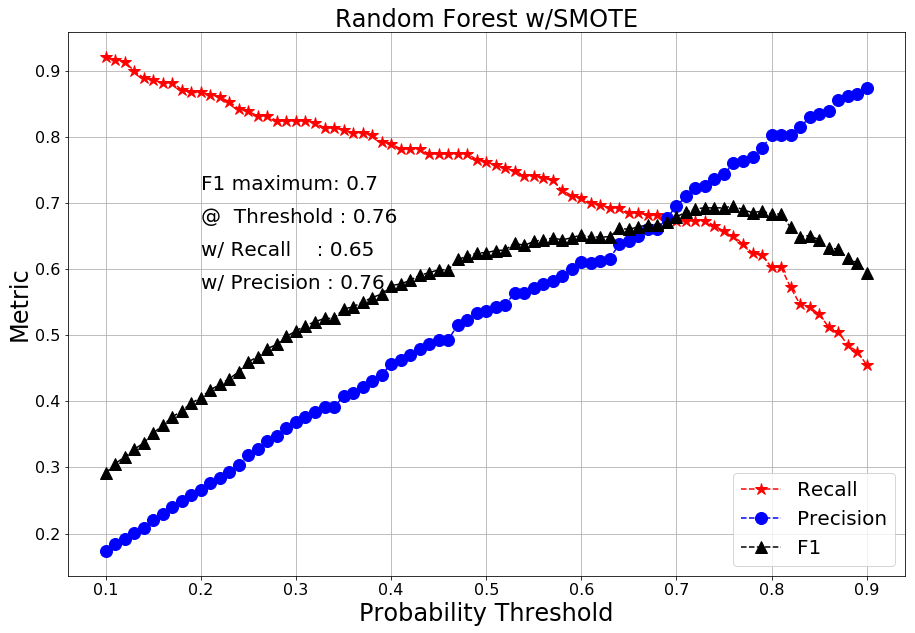

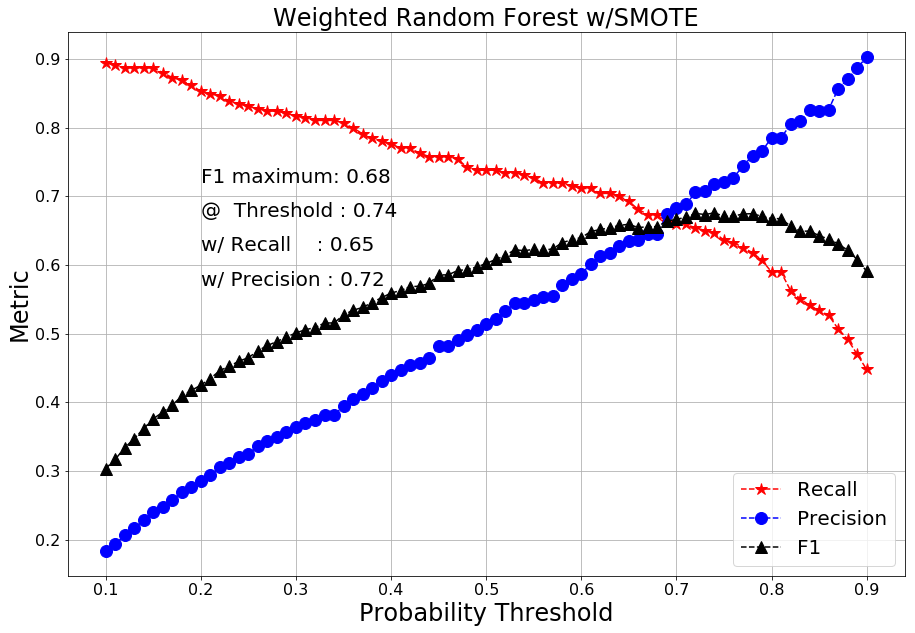

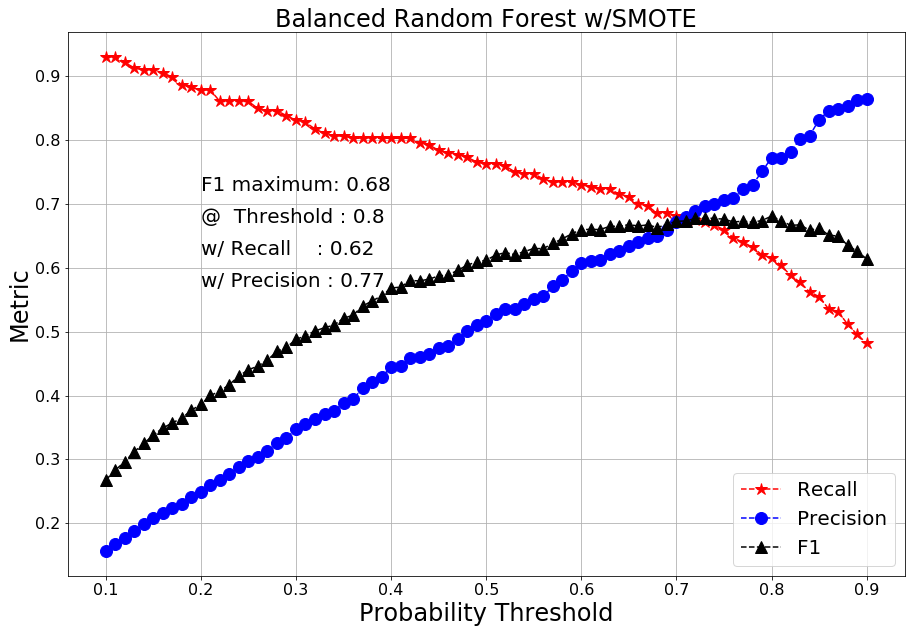

In [72]:
recall    = np.mean(RFC_recall, axis=0)
precision = np.mean(RFC_precision, axis=0)
f1        = np.mean(RFC_f1, axis=0)
    

plt.figure(figsize=((15,10)))
plt.title('Random Forest w/SMOTE', fontsize=24)
plt.plot(thresh_arr, recall,'r--*', label = 'Recall', markersize = 12)
plt.plot(thresh_arr, precision,'b--o', label = 'Precision', markersize = 12)
plt.plot(thresh_arr, f1,'k--^', label = 'F1', markersize = 12)
plt.xlabel('Probability Threshold', fontsize=24)
plt.ylabel('Metric', fontsize=24)

plt.legend(prop={'size': 20}) 
plt.text(0.2, 0.72, f'F1 maximum: {round(max(f1),2)}', fontsize=20)
plt.text(0.2, 0.67,  f'@  Threshold : {round(thresh_arr[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.62, f'w/ Recall    : {round(recall[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.57,  f'w/ Precision : {round(precision[np.argmax(f1)],2)}', fontsize=20)
plt.grid()
plt.savefig('Mam_RF_wSMOTE_'+dt.datetime.today().strftime('%Y-%m-%d_%H-%M')+'.pdf')
# ---------------------------------------------------------------------------------------------

recall    = np.mean(WRF_recall, axis=0)
precision = np.mean(WRF_precision, axis=0)
f1        = np.mean(WRF_f1, axis=0)
    

plt.figure(figsize=((15,10)))
plt.title('Weighted Random Forest w/SMOTE', fontsize=24)
plt.plot(thresh_arr, recall,'r--*', label = 'Recall', markersize = 12)
plt.plot(thresh_arr, precision,'b--o', label = 'Precision', markersize = 12)
plt.plot(thresh_arr, f1,'k--^', label = 'F1', markersize = 12)
plt.xlabel('Probability Threshold', fontsize=24)
plt.ylabel('Metric', fontsize=24)


plt.legend(prop={'size': 20}) 
plt.text(0.2, 0.72, f'F1 maximum: {round(max(f1),2)}', fontsize=20)
plt.text(0.2, 0.67,  f'@  Threshold : {round(thresh_arr[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.62, f'w/ Recall    : {round(recall[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.57,  f'w/ Precision : {round(precision[np.argmax(f1)],2)}', fontsize=20)
plt.grid()
plt.savefig('Mam_WRF_wSMOTE_'+dt.datetime.today().strftime('%Y-%m-%d_%H-%M')+'.pdf')

# ---------------------------------------------------------------------------------------------

recall    = np.mean(BRF_recall, axis=0)
precision = np.mean(BRF_precision, axis=0)
f1        = np.mean(BRF_f1, axis=0)
    

plt.figure(figsize=((15,10)))
plt.title('Balanced Random Forest w/SMOTE', fontsize=24)
plt.plot(thresh_arr, recall,'r--*', label = 'Recall', markersize = 12)
plt.plot(thresh_arr, precision,'b--o', label = 'Precision', markersize = 12)
plt.plot(thresh_arr, f1,'k--^', label = 'F1', markersize = 12)
plt.xlabel('Probability Threshold', fontsize=24)
plt.ylabel('Metric', fontsize=24)

plt.legend(prop={'size': 20}) 
plt.text(0.2, 0.72, f'F1 maximum: {round(max(f1),2)}', fontsize=20)
plt.text(0.2, 0.67,  f'@  Threshold : {round(thresh_arr[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.62, f'w/ Recall    : {round(recall[np.argmax(f1)],2)}', fontsize=20)
plt.text(0.2, 0.57,  f'w/ Precision : {round(precision[np.argmax(f1)],2)}', fontsize=20)
plt.grid()
plt.savefig('Mam_BRF_wSMOTE_'+dt.datetime.today().strftime('%Y-%m-%d_%H-%M')+'.pdf')

